In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    get_logging_dir,
    plot_data_split,
    plot_predictions,
)
from models.SmartAverageLayer import SmartAverageLayer

from experiments.artificial_1D_linear.my_fed_util import (
    train_client,
    register_client_test_losses,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
NUM_CLIENTS = 2

COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 100

SPLIT_TYPE = "random"

In [4]:
CLIENT_IDs = range(NUM_CLIENTS)

BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [11, 12, 11, 12]

LOSS_FN = torch.nn.MSELoss()

In [5]:
def register_hyperparameters(writer, last_loss):
    writer.add_hparams(
        {
            "client_epochs": CLIENT_EPOCHS,
            "num_clients": NUM_CLIENTS,
            "communication_rounds": COMMUNICATION_ROUNDS,
            "split_type": SPLIT_TYPE,
            "architecture": str(ARCHITECTURE),
        },
        {
            "MSE Test": last_loss,
        },
        run_name=".",
    )

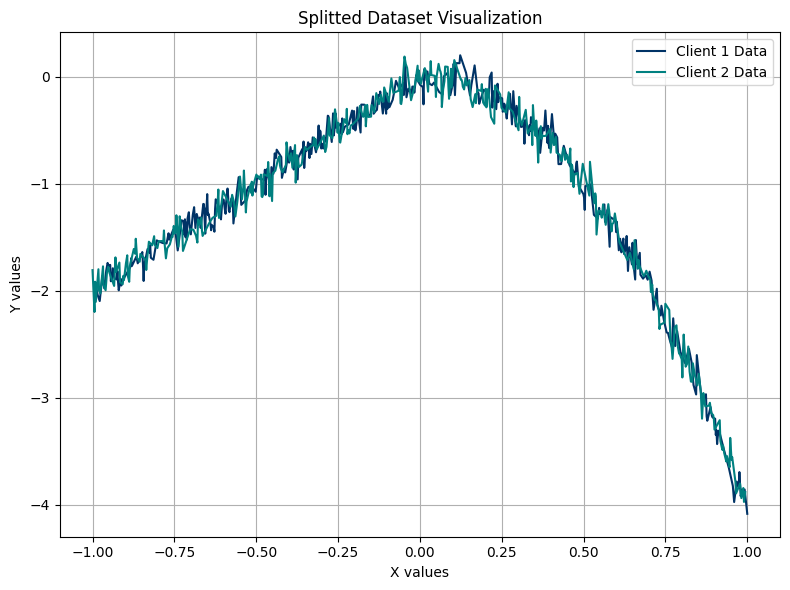

In [6]:
model_name = f"MyFed_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name))

clients = [
    SmartAverageLayer.from_scratch(INPUT_FEATURES, OUTPUT_FEATURES, NUM_CLIENTS, client_id, ARCHITECTURE)
    for client_id in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)

In [7]:
print(clients[0])

SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=11, bias=False)
      (1): Linear(in_features=12, out_features=12, bias=False)
      (2): Linear(in_features=13, out_features=11, bias=False)
      (3): Linear(in_features=12, out_features=12, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=13, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)


Communication Round 9/10
 global model:  SmartAverageLayer(
  (prediction_network): MultiOutputNet(
    (activation): ReLU()
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=17, bias=False)
      (1): Linear(in_features=18, out_features=118, bias=False)
      (2): Linear(in_features=119, out_features=241, bias=False)
      (3): Linear(in_features=242, out_features=502, bias=False)
    )
    (output_layers): ModuleList(
      (0-1): 2 x Linear(in_features=503, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
    )
  )
)

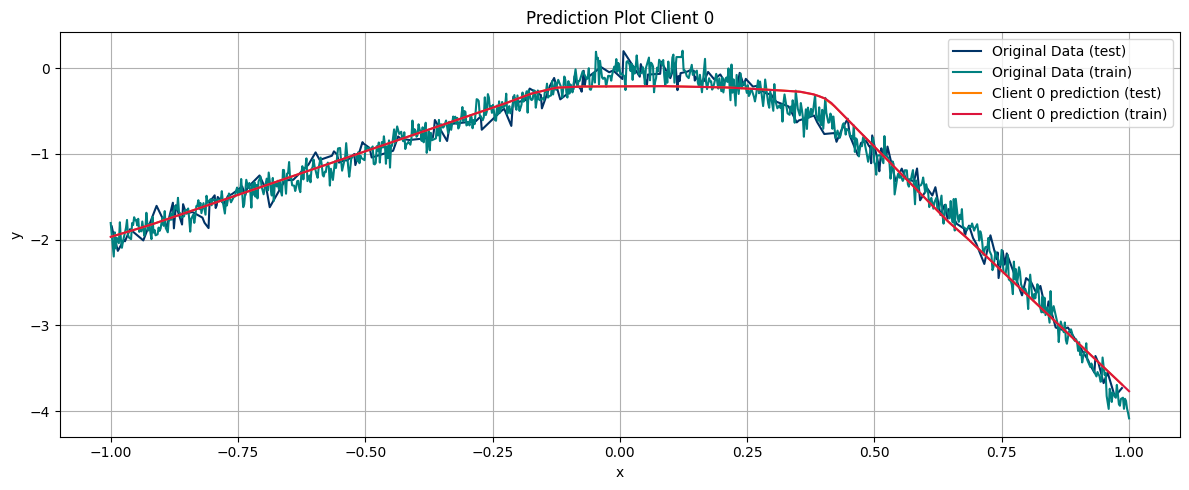

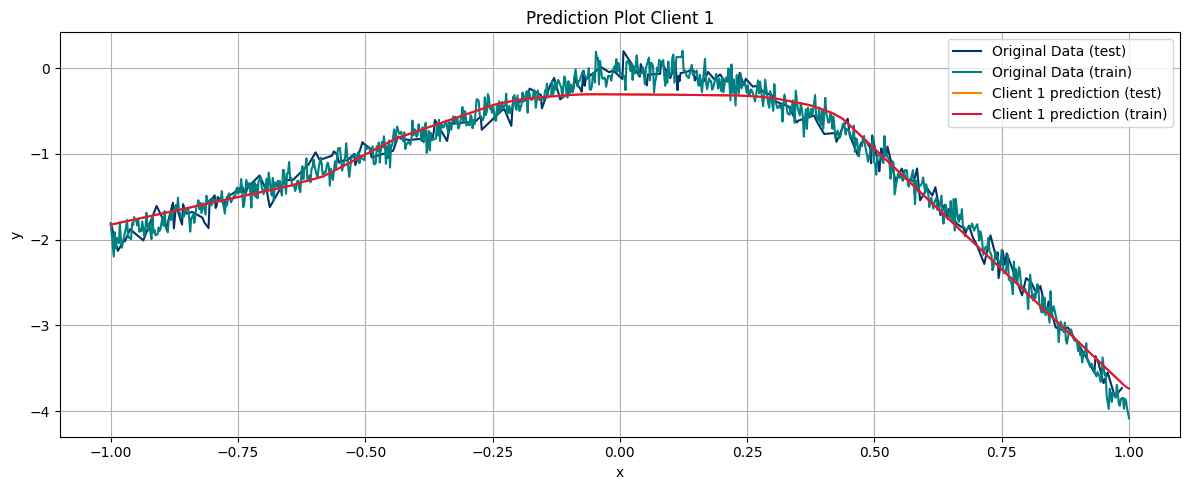

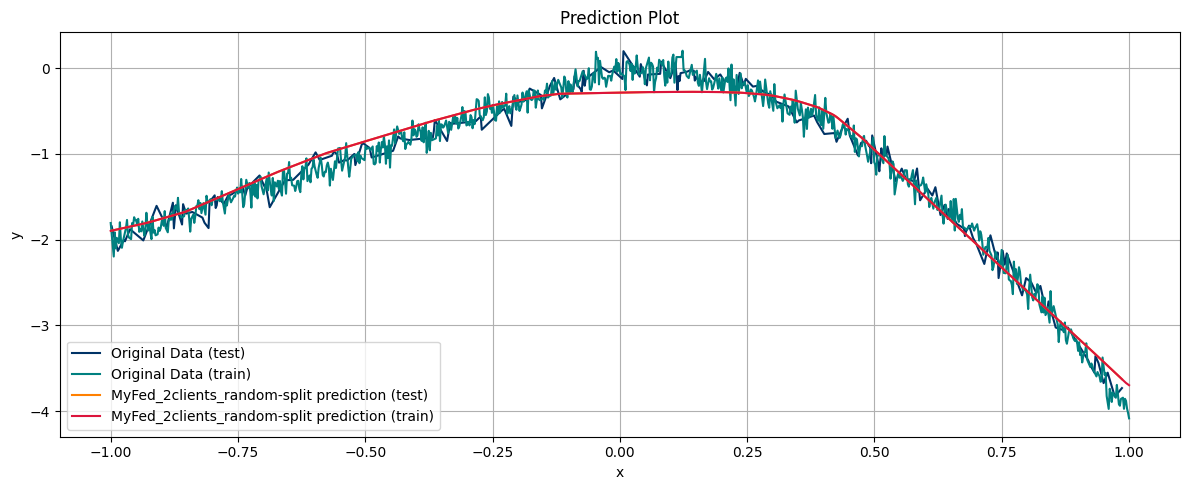

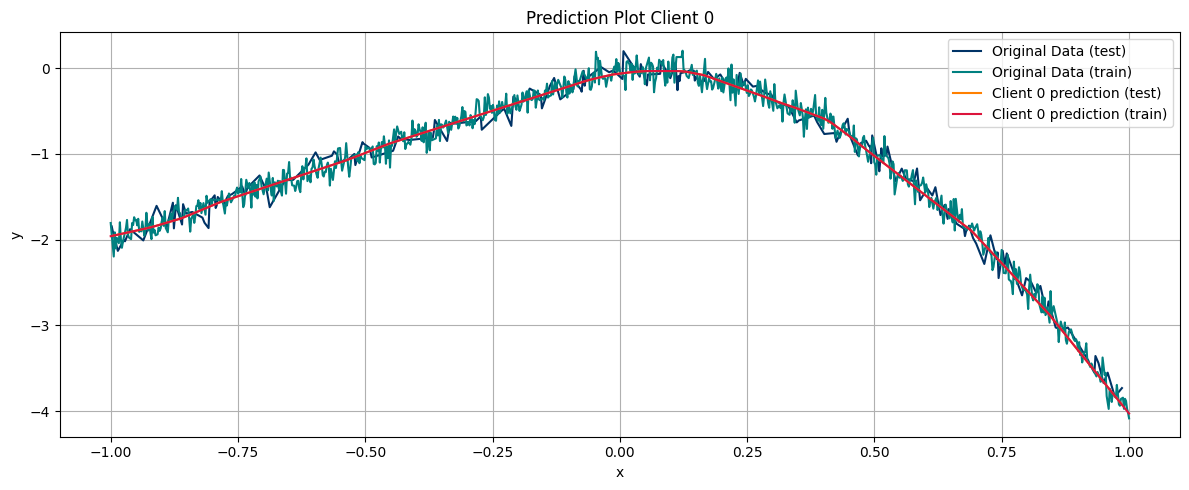

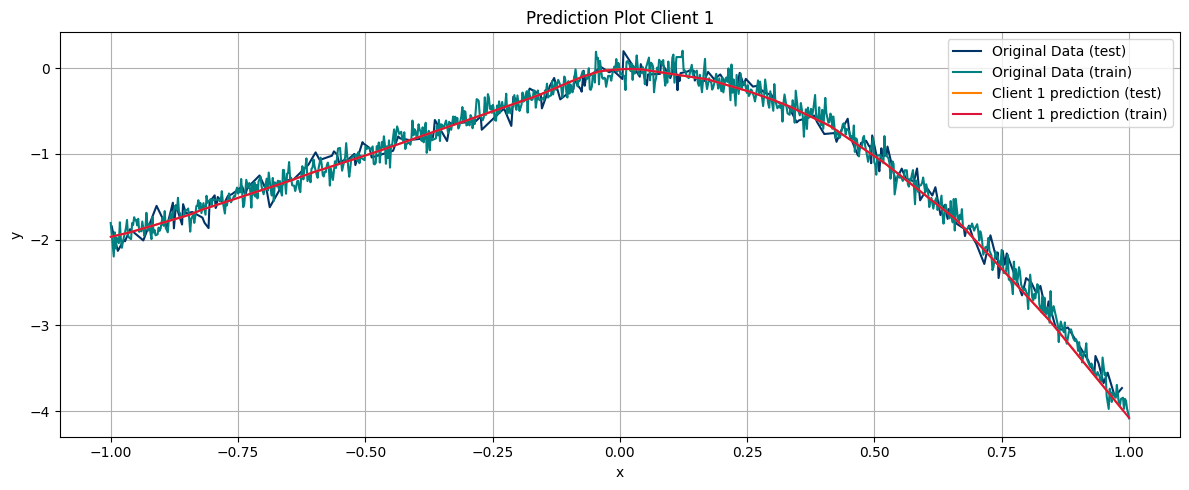

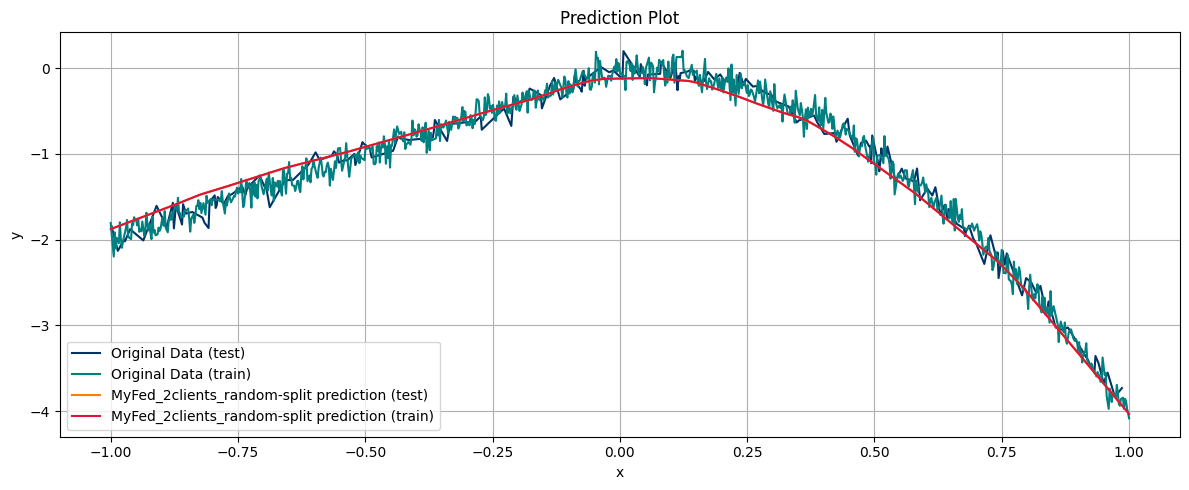

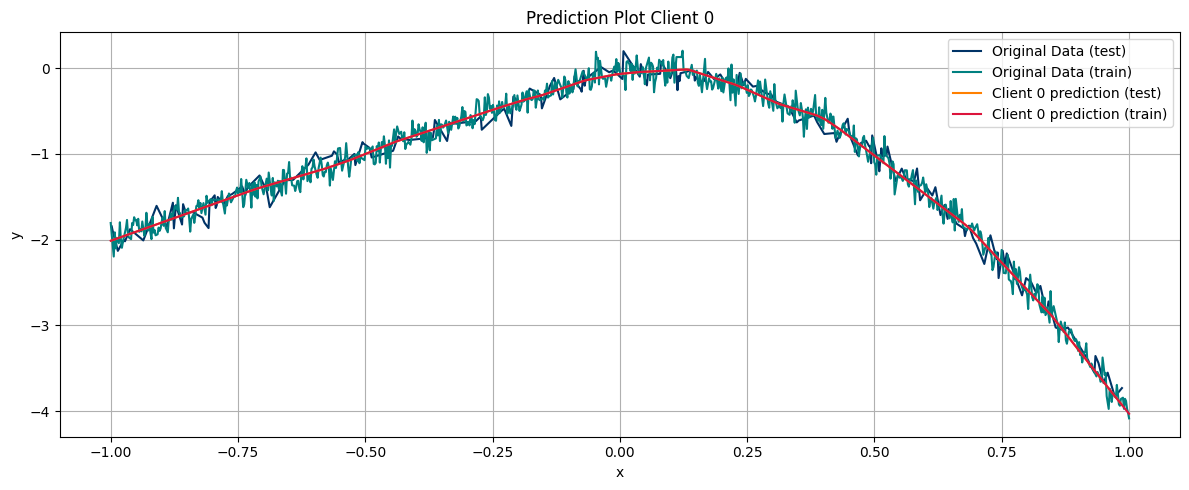

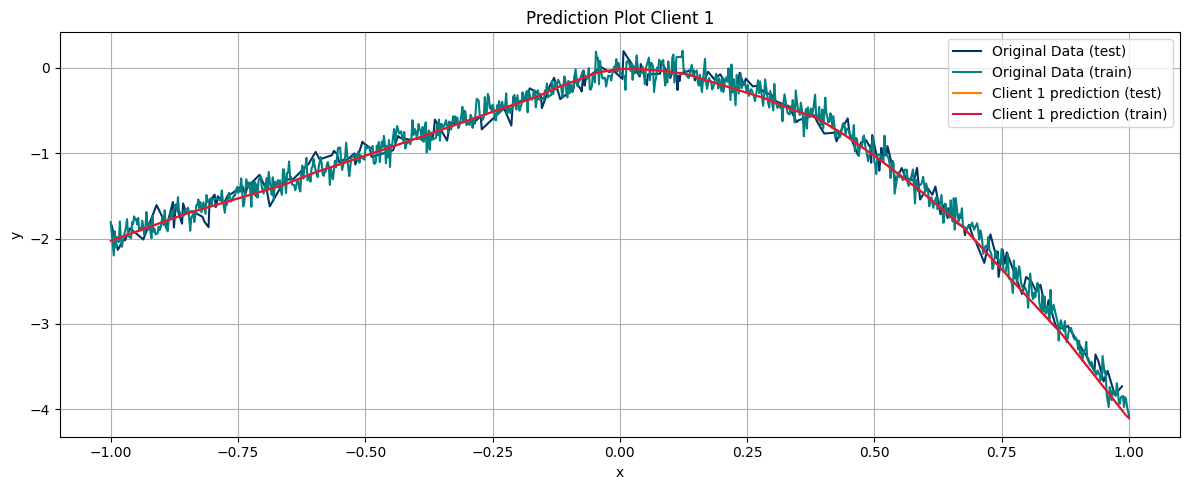

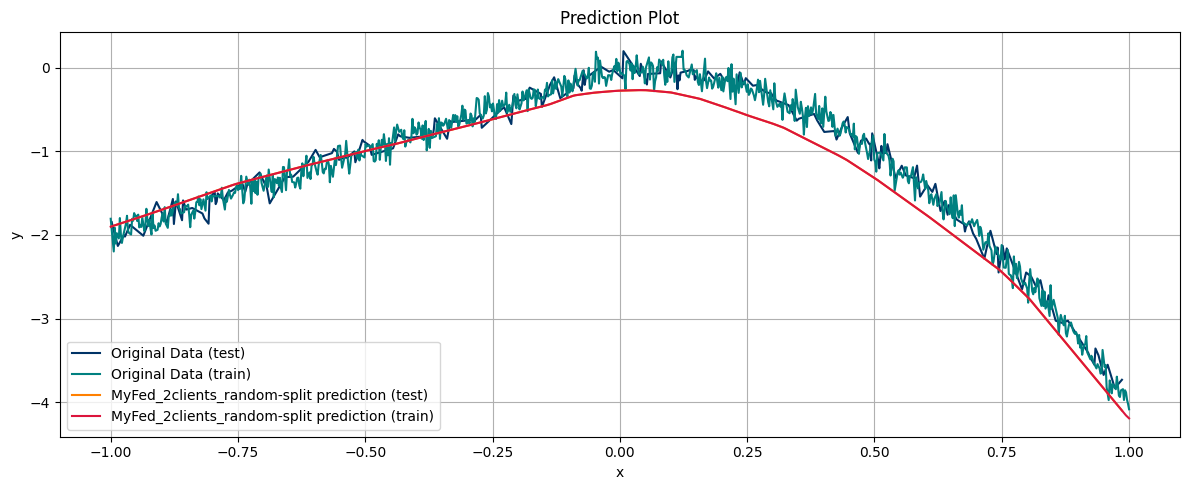

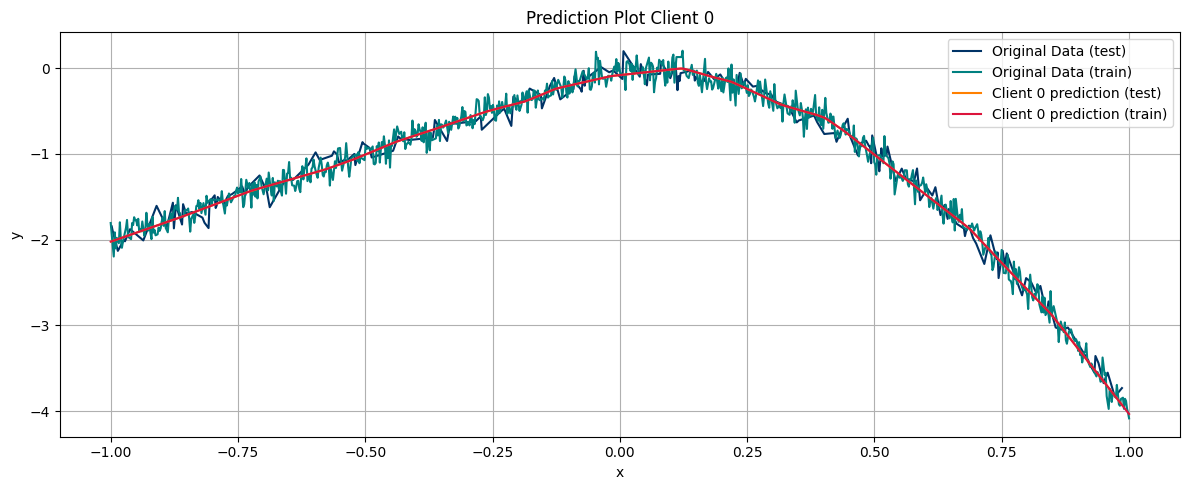

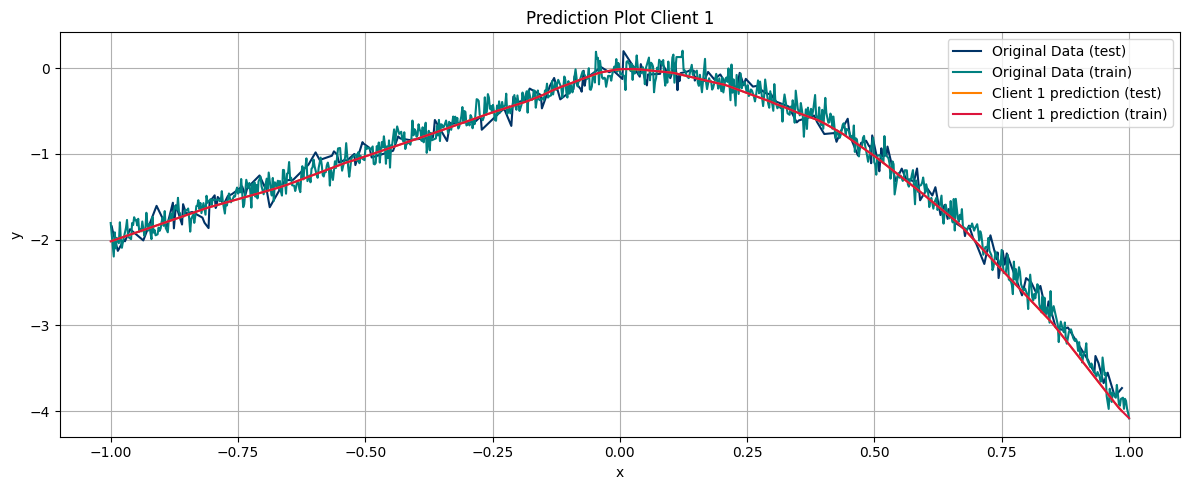

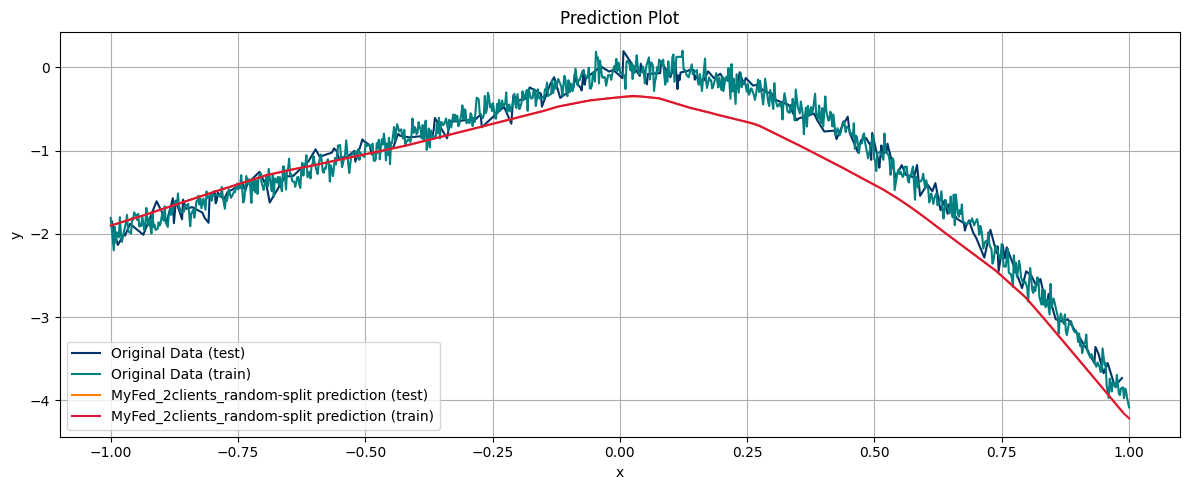

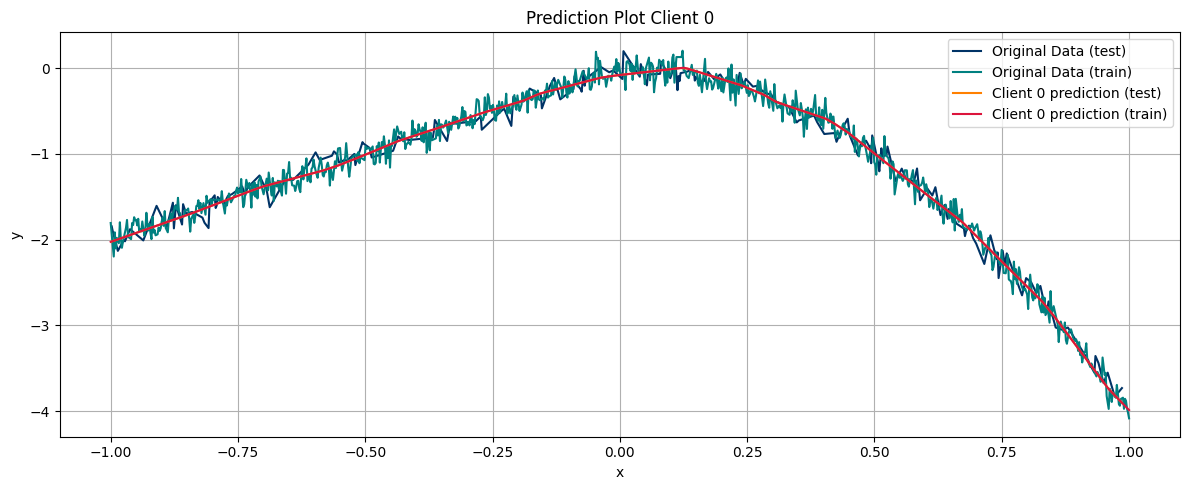

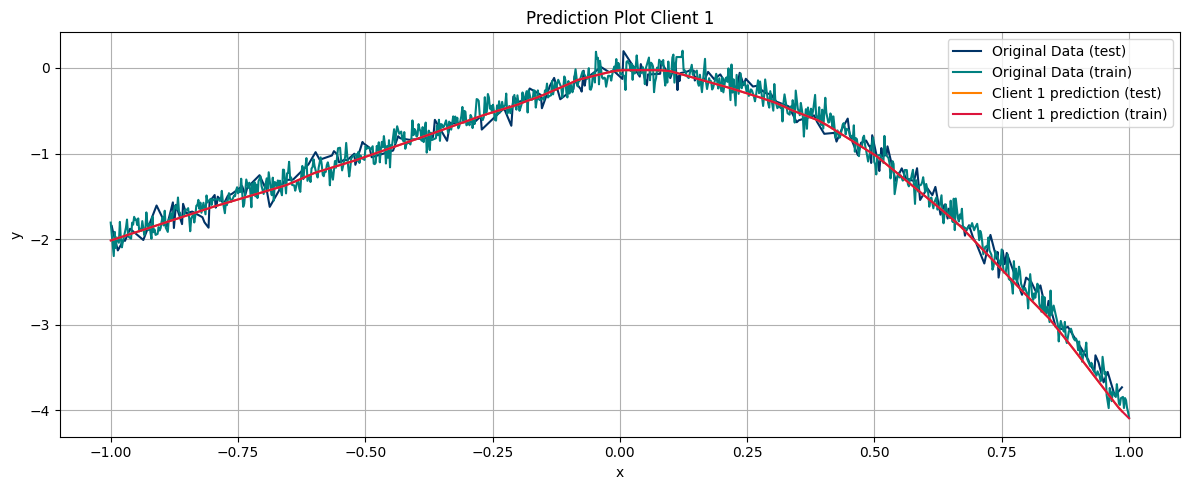

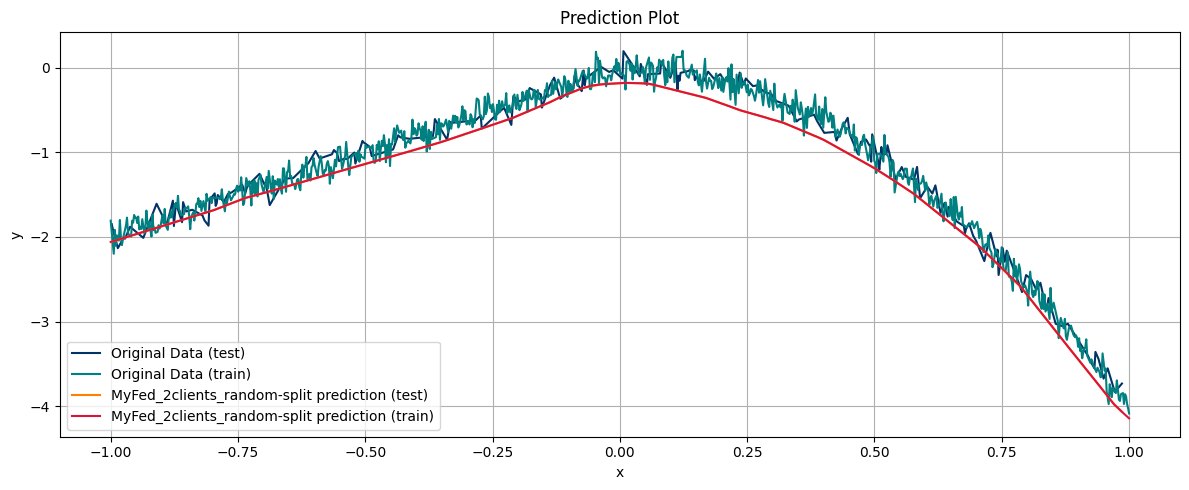

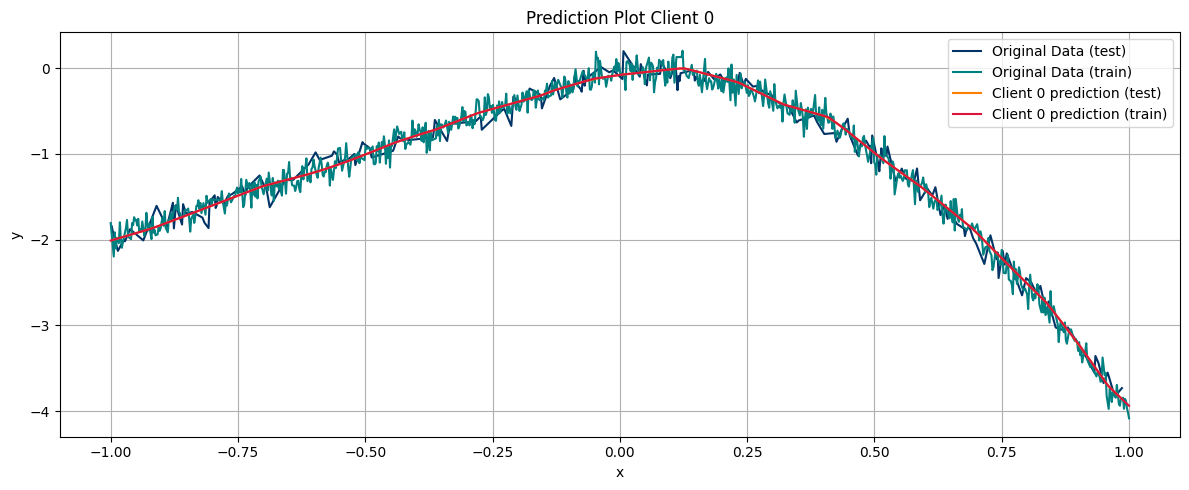

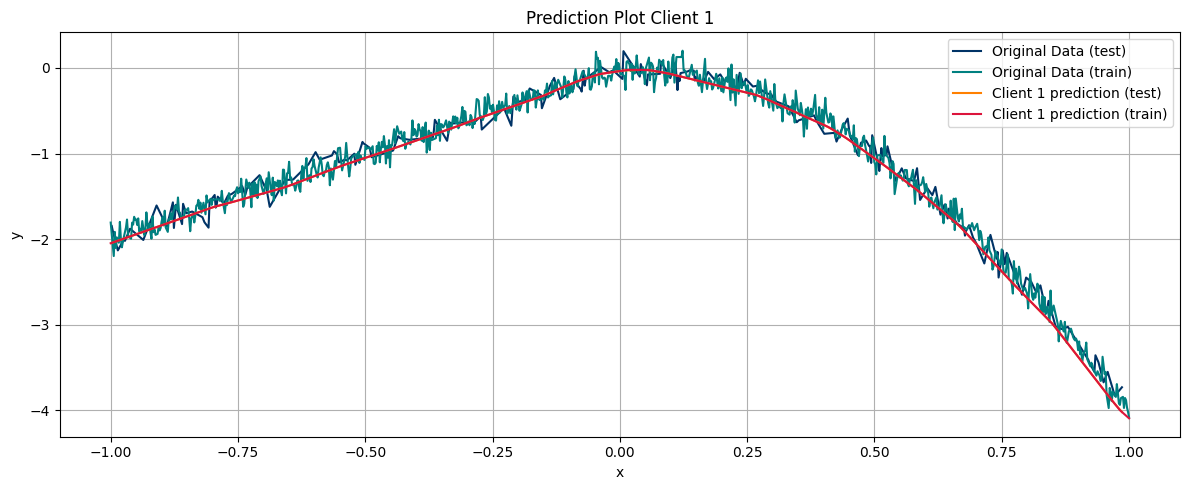

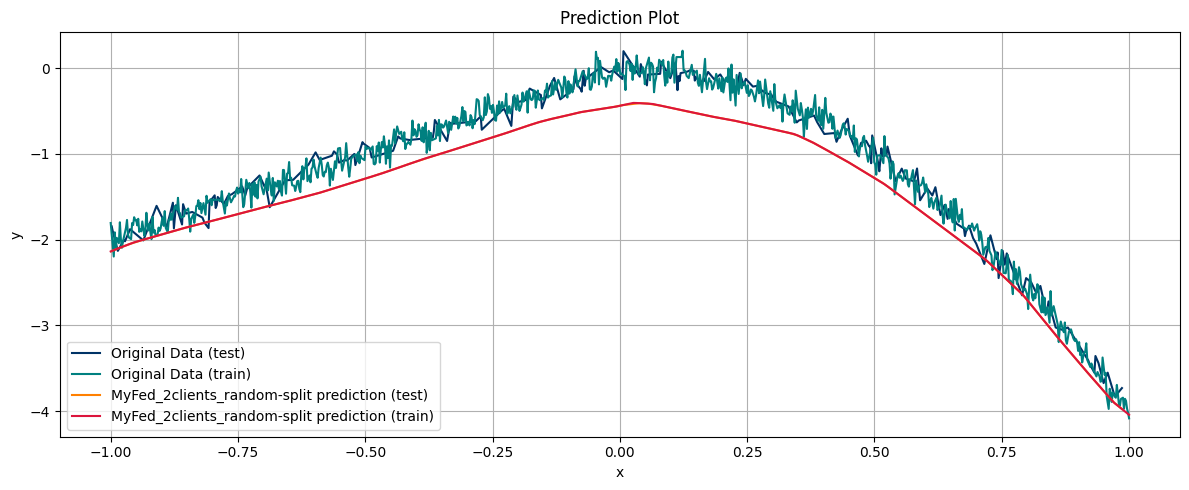

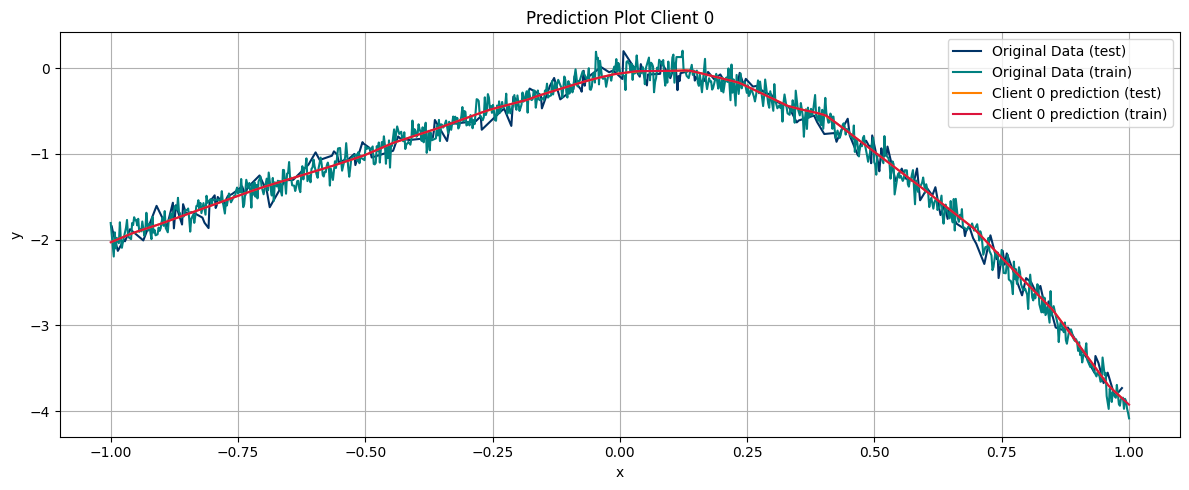

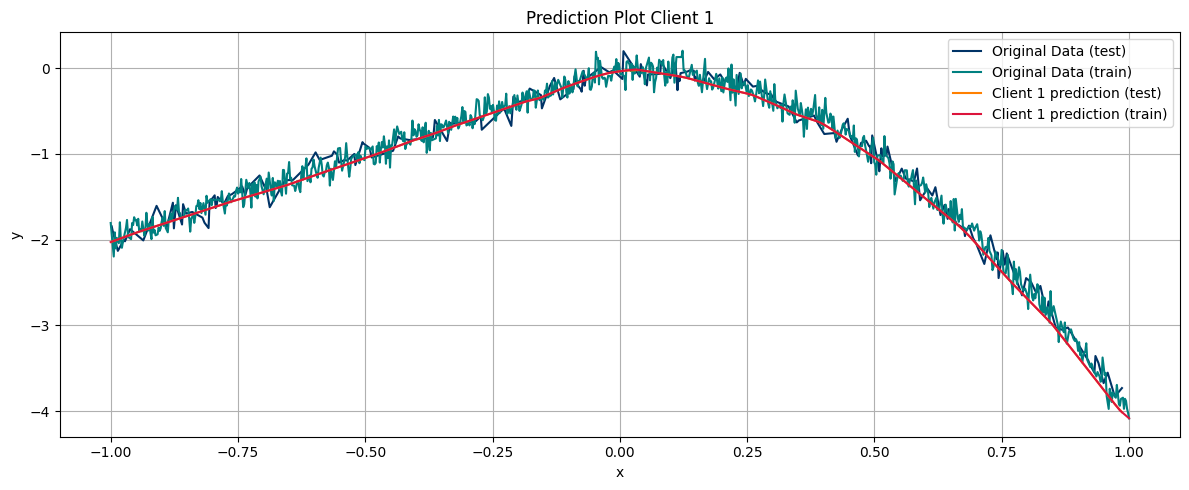

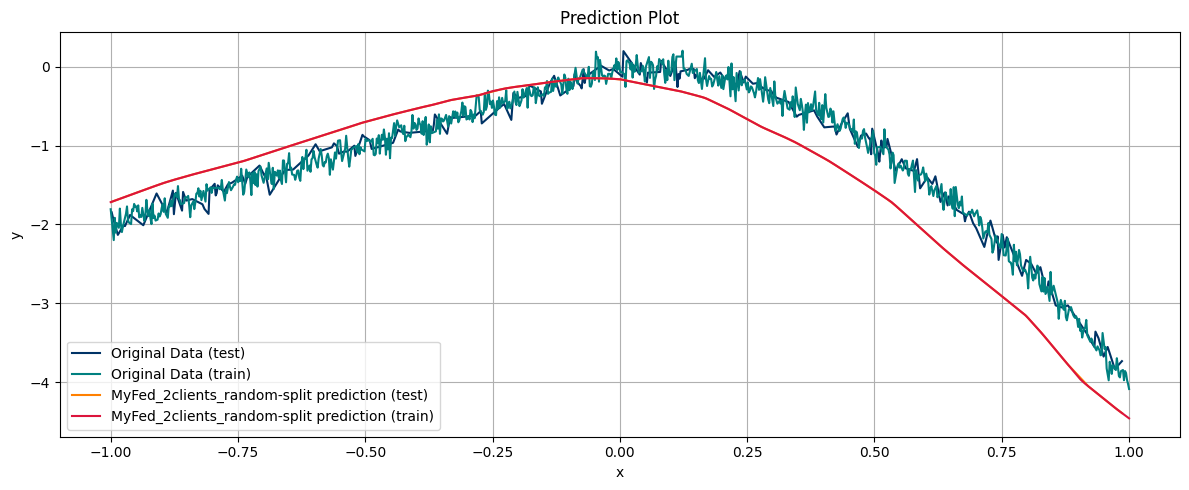

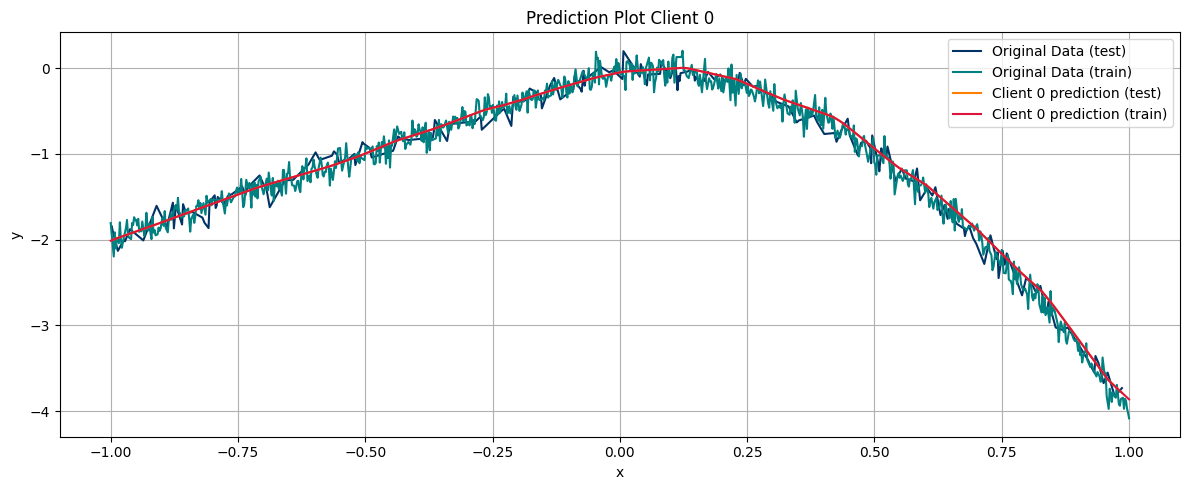

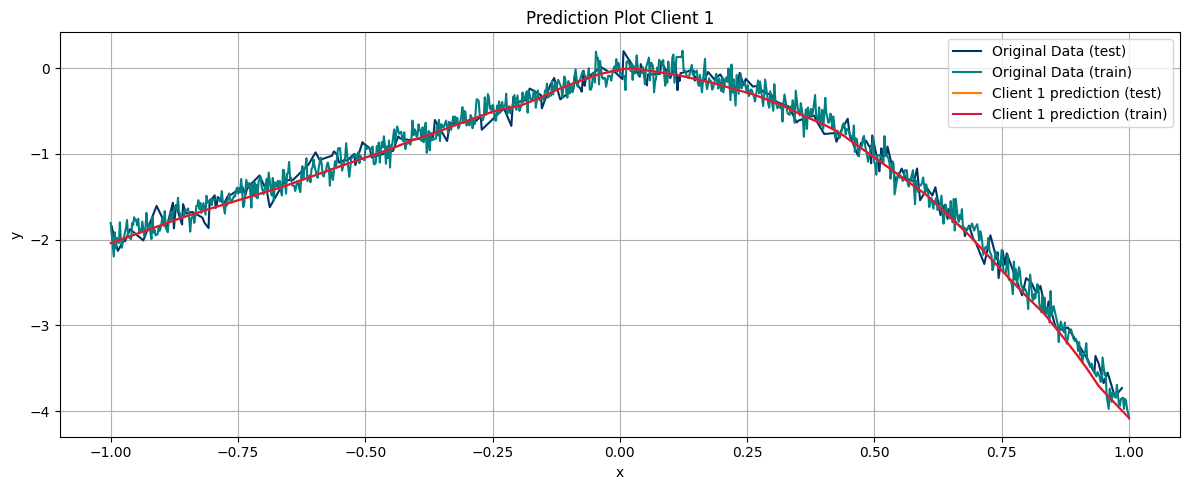

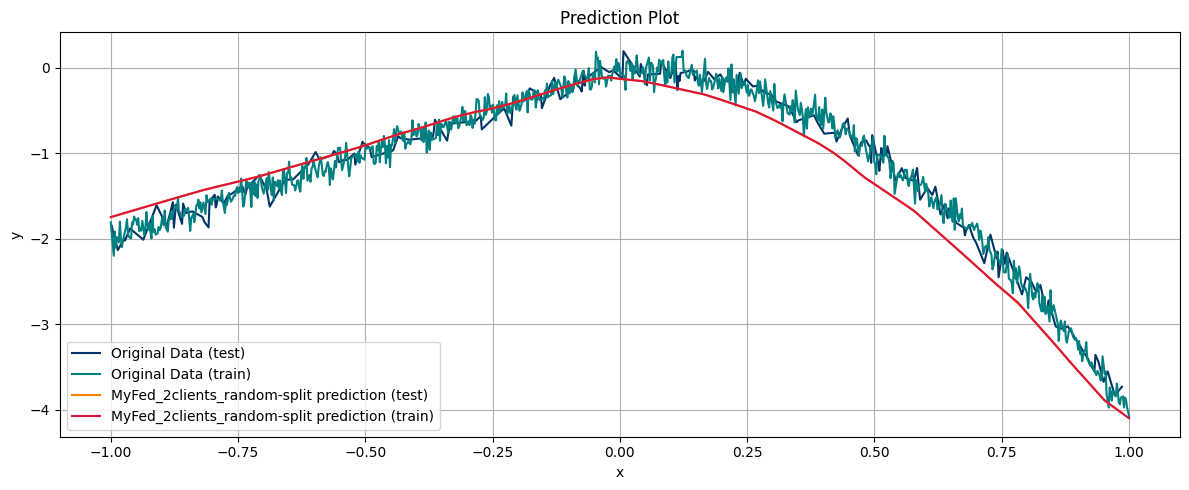

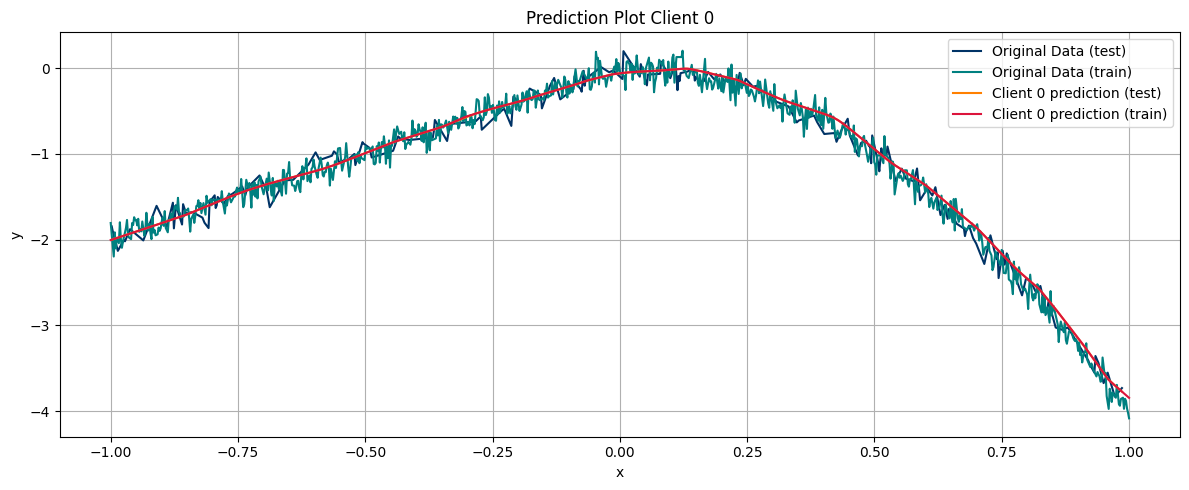

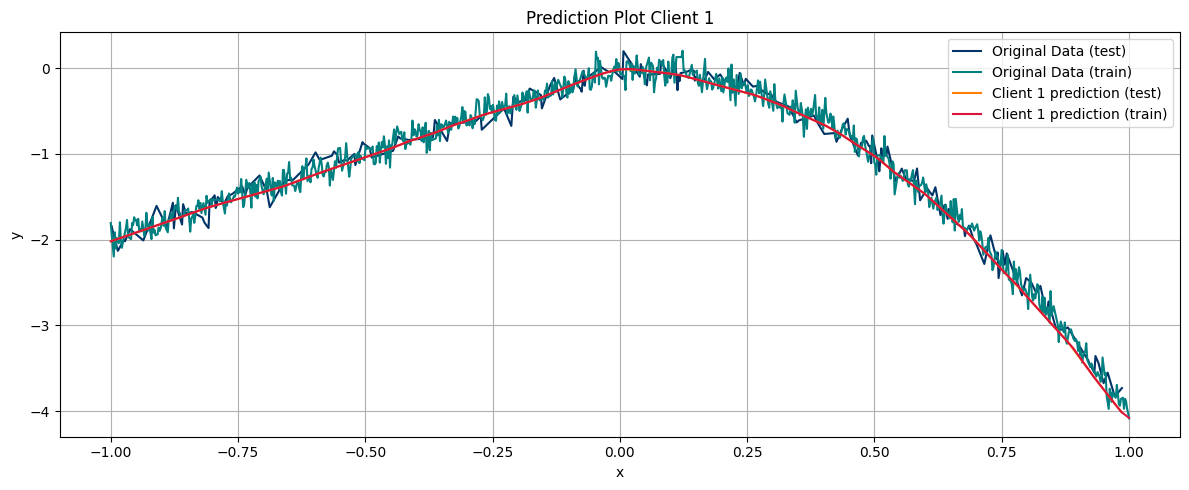

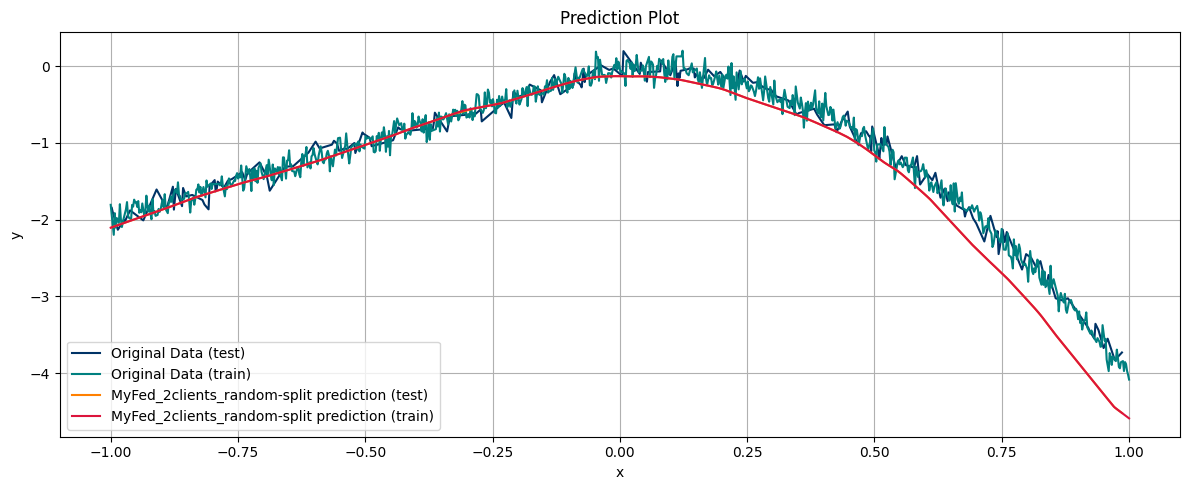

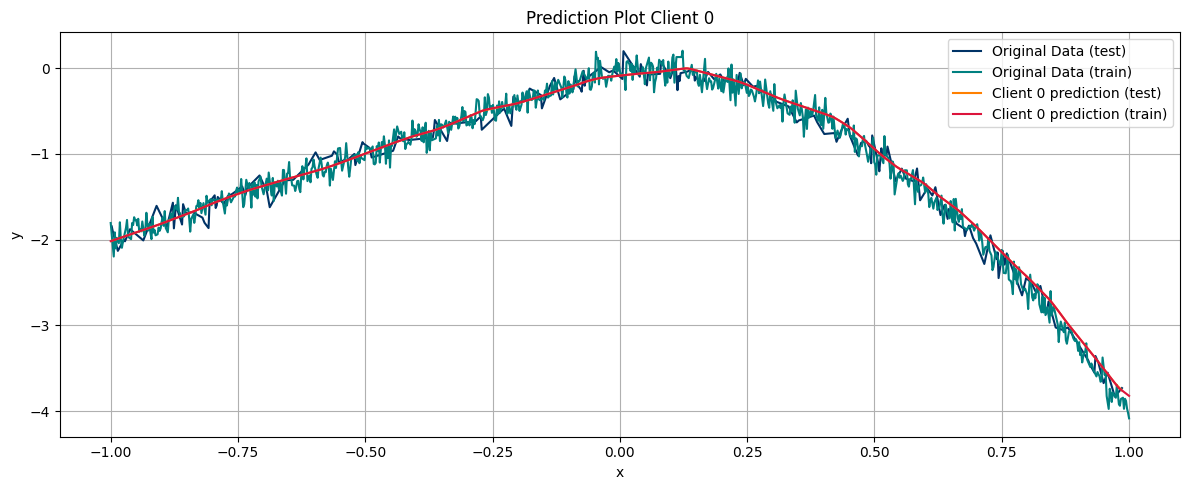

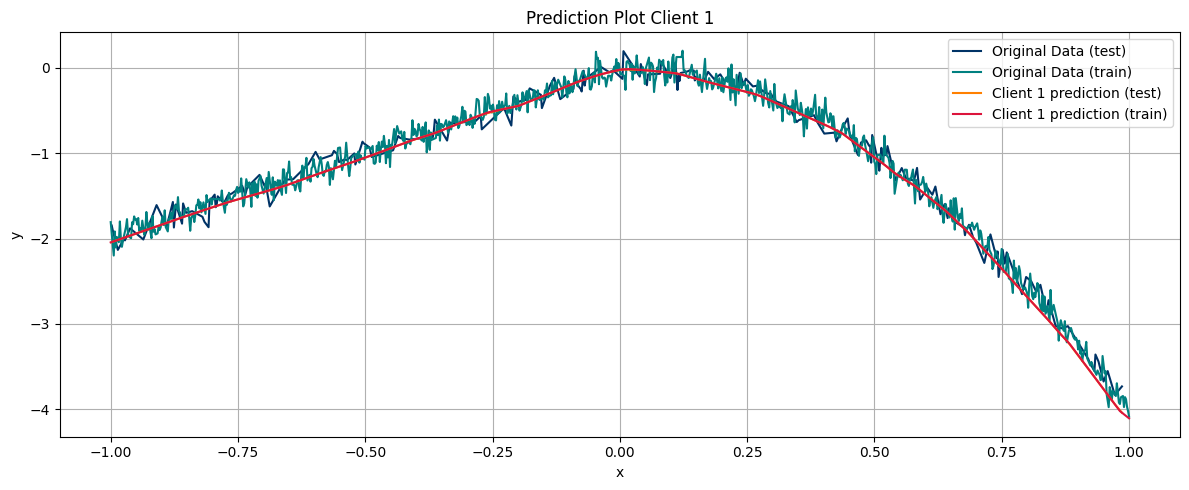

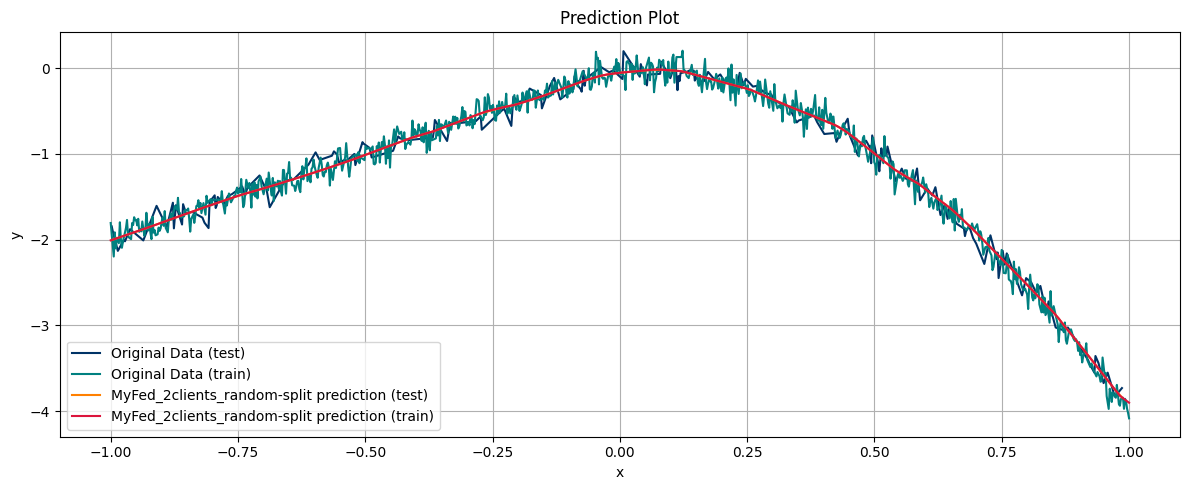

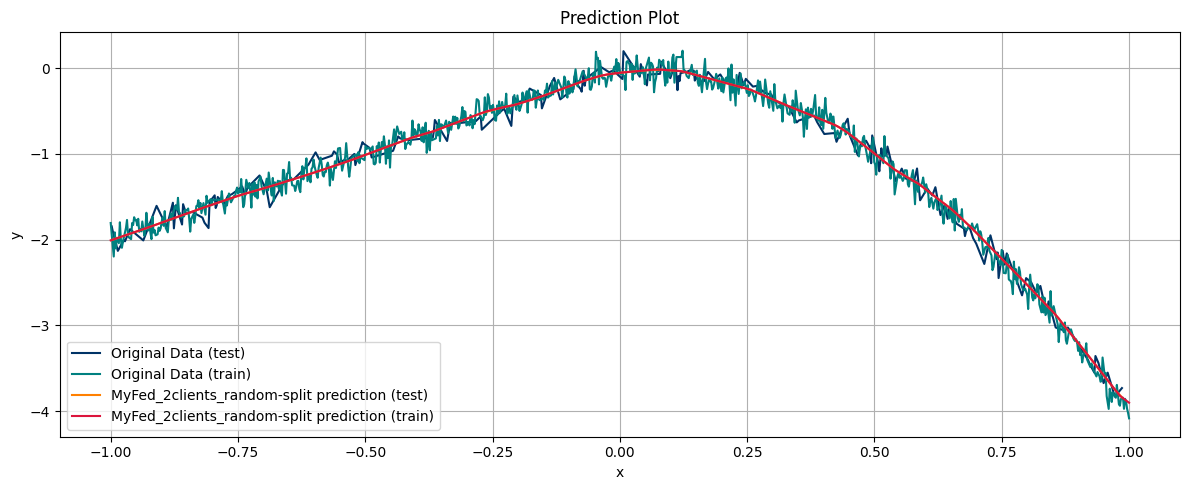

In [8]:
for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        train_client(
            client_no=client_no,
            client_model=client,
            data_loader=client_train_dataloaders[client_no],
            loss_fn=LOSS_FN,
            no_epochs=CLIENT_EPOCHS,
            communication_round=cr,
            writer=writer,
        )

    register_client_test_losses(
        clients=clients, client_ids=CLIENT_IDs, writer=writer, communication_round=cr
    )

    global_model = SmartAverageLayer.get_global_model(
        clients,
        similarity_threshold_in_degree=15,
        add_noise= cr < COMMUNICATION_ROUNDS - 1,
    )

    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    #### ----- Unimportant ----- NOTE: remove####################################################################################
    from IPython.display import clear_output

    clear_output(wait=True)
    print(f"Communication Round {cr}/{COMMUNICATION_ROUNDS}")
    print("\r global model: ", global_model, end="")
    # print("\n\n GLOBAL MODEL\n", list(global_model.named_parameters()))

    #### //// ----- Unimportant ------------------------------------------------------------------------------------------------

    clients = [global_model.get_client_model(client_id) for client_id in CLIENT_IDs]


    ###!!!!!!!!!!!!! NOTE:remove################################################################################################
    plot_predictions(global_model, model_name, writer, epoch=cr)
    # --------------------------------------------------------------------------------------------------------------------------

plot_predictions(global_model, model_name, writer)
register_hyperparameters(writer, last_loss=evaluate(global_model))
writer.close()

In [9]:
print(global_model.prediction_network.full_representation())
print(global_model.prediction_mask)

SelfLearningNet Weights: (training on output None)
Layer 0 Weights:
[[-0.9099491  -0.41471982]
 [-0.9597941   0.28070503]
 [ 0.70021653 -0.71393025]
 [ 0.04234791  0.99910176]
 [ 0.8866501   0.4624411 ]
 [-0.7874186   0.6164186 ]
 [ 0.9748579  -0.2228255 ]
 [ 0.8191516   0.5735765 ]
 [ 0.825819    0.5639351 ]
 [-0.3769011  -0.9262535 ]
 [ 0.6560726  -0.75468636]
 [ 0.9659685  -0.25865433]
 [-0.59797585 -0.8013975 ]
 [-0.970914   -0.23942839]
 [-0.64522594  0.7639445 ]
 [-0.61361563  0.78945446]
 [-0.5462748   0.83755577]]
Layer 1 Weights:
[[-0.19515164  0.17826214  0.27150074 ... -0.19010767 -0.08647663
  -0.11658488]
 [-0.1728253   0.14019741  0.23525111 ... -0.22435492 -0.10817497
  -0.14048557]
 [-0.02508684 -0.06542492 -0.6849712  ... -0.16529697  0.16981104
   0.19281545]
 ...
 [ 0.09396581 -0.01208241  0.10432974 ... -0.22547707  0.46929455
  -0.18988997]
 [-0.08489963 -0.22905311  0.0079723  ... -0.20819575  0.48669153
  -0.14528944]
 [-0.13447225 -0.17258932  0.00587125 ... -0.

In [10]:
for client in clients:
    print(client.prediction_network.full_representation())
    print(client.prediction_mask)

SelfLearningNet Weights: (training on output 0)
Layer 0 Weights:
[[-0.9099491  -0.41471982]
 [-0.9597941   0.28070503]
 [ 0.70021653 -0.71393025]
 [ 0.04234791  0.99910176]
 [ 0.8866501   0.4624411 ]
 [-0.7874186   0.6164186 ]
 [ 0.9748579  -0.2228255 ]
 [ 0.8191516   0.5735765 ]
 [ 0.825819    0.5639351 ]
 [-0.3769011  -0.9262535 ]
 [ 0.6560726  -0.75468636]
 [ 0.9659685  -0.25865433]
 [-0.59797585 -0.8013975 ]
 [-0.970914   -0.23942839]
 [-0.64522594  0.7639445 ]
 [-0.61361563  0.78945446]
 [-0.5462748   0.83755577]]
Layer 1 Weights:
[[-0.19515164  0.17826214  0.27150074 ... -0.19010767 -0.08647663
  -0.11658488]
 [-0.1728253   0.14019741  0.23525111 ... -0.22435492 -0.10817497
  -0.14048557]
 [-0.02508684 -0.06542492 -0.6849712  ... -0.16529697  0.16981104
   0.19281545]
 ...
 [ 0.09396581 -0.01208241  0.10432974 ... -0.22547707  0.46929455
  -0.18988997]
 [-0.08489963 -0.22905311  0.0079723  ... -0.20819575  0.48669153
  -0.14528944]
 [-0.13447225 -0.17258932  0.00587125 ... -0.166